## Лабораторная №4. Обработка звука

## Курс орнитологии

1. Реализуйте модель для извлечения признаков из голоса птиц. За основу можно брать:

    * преобразование в аудиофичи (например как mfcc в лекции. Конкретно это преобразование использовать нельзя)
    * обученные поверх аудиофич ML модели

2. С помощью модели и одного из предложенных датасетов создайте эмбеддинги пения птиц. Создайте эмбеддинги нескольких записей каждого вида птиц. Визуализируйте эмбеддинги. Для визуализации рекомендуется использовать подмножество видов птиц

3. Аргументируйте почему ваша модель хорошо извлекает признаки из аудио.

     * Покажите кластеризацию эмбеддингов по видам

4. С помощью эмбеддингов найдите похожие по звучанию виды птиц. Выведите примеры их пения в ноутбуке.


## Наборы данных
Датасет американских птиц

Первым делом импортируем библиотеки для решения задачи

In [21]:
import torchaudio
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython
import pandas as pd
import umap.umap_ as umap

Создаем экземпляр класса LFCC для работы с аудио.
Преобразование LFCC вычисляет логарифмическую мощность спектра аудиозаписи в определенных частотных полосах и вычисляет коэффициенты кепстра на основе полученных спектральных данных.
В целом, преобразование LFCC и коэффициенты кепстра помогают представить звуковой сигнал в более удобной и информативной форме, что упрощает его обработку и анализ.

In [22]:
transform = torchaudio.transforms.LFCC()

Берем наш набор данных и извлекаем имена наших птиц в отдельный массив и сортируем уникальные имена

In [23]:
data = pd.read_csv('data/bird_songs_metadata.csv')

names = sorted(list(set(data['name'])))
names

['American Robin',
 "Bewick's Wren",
 'Northern Cardinal',
 'Northern Mockingbird',
 'Song Sparrow']

Распределим все данные из набора по именам. Сначала запишем название 5 файлов для каждого имени которых хотим загрузить. Загружаем каждый из 25 файлов с помощью библиотеки librosa и преобразуем их в тензоры.

In [24]:
name_to_set = {name: data[data['name'] == name] for name in names}

file_names = []
for name in names:
    for i, row in name_to_set[name].iterrows():
        file_names.append(row['filename'])
        if not len(file_names) % 5:
            break

loaded_songs = [torch.Tensor(librosa.load('data/wavfiles/' + name)[0]) for name in file_names]
print(loaded_songs, len(loaded_songs))

[tensor([ 0.0068,  0.0150, -0.0202,  ..., -0.1375, -0.0725,  0.0208]), tensor([-0.0237,  0.0089,  0.0317,  ..., -0.0407, -0.0173,  0.0345]), tensor([ 0.4478,  0.3117, -0.1737,  ...,  0.0653,  0.0394,  0.0021]), tensor([-0.5915, -0.5405, -0.2253,  ..., -0.0546,  0.0138,  0.0831]), tensor([ 0.0544,  0.1114,  0.0646,  ...,  0.0302, -0.0412, -0.0151]), tensor([-0.0109, -0.0365, -0.0889,  ..., -0.1846, -0.1899, -0.2019]), tensor([0.2949, 0.1882, 0.0849,  ..., 0.0371, 0.0494, 0.0532]), tensor([ 0.0618,  0.0422,  0.0238,  ..., -0.0858, -0.0807, -0.1157]), tensor([0.2891, 0.2558, 0.2524,  ..., 0.0177, 0.0044, 0.0020]), tensor([-0.0208,  0.0601,  0.0353,  ..., -0.0637, -0.0709, -0.0771]), tensor([-0.0554,  0.1547,  0.2703,  ...,  0.0447,  0.0255, -0.0672]), tensor([-0.0874,  0.0630,  0.1240,  ..., -0.0307,  0.0172,  0.0838]), tensor([ 0.2789, -0.0627, -0.2966,  ...,  0.0692,  0.0944,  0.0754]), tensor([-0.0491,  0.0839,  0.1238,  ..., -0.0225,  0.0532,  0.0631]), tensor([ 0.2295,  0.1798,  0.04

Применяем функцию LFCC на каждый аудиофайл для анализа и извлечения характеристик звукового сигнала, что делает его более удобным для последующей обработки и анализа. Создадим эмбеддинги нескольких записей каждого вида птиц. Визуализируем эти эмбеддинги

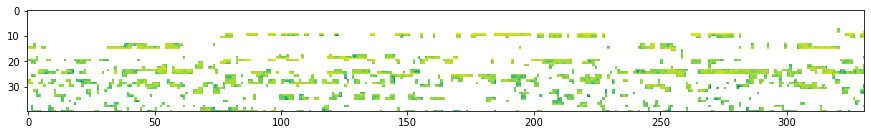

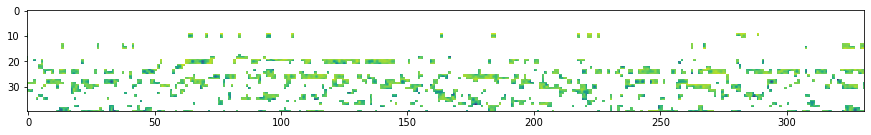

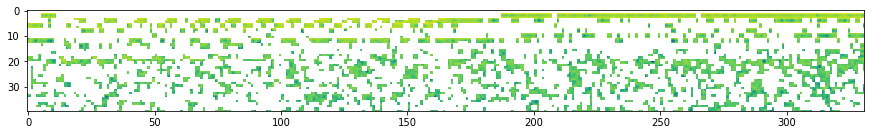

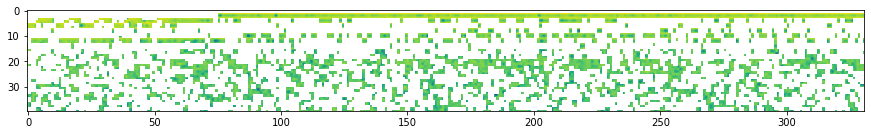

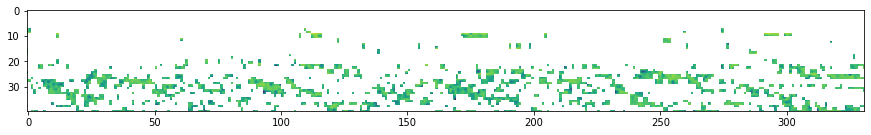

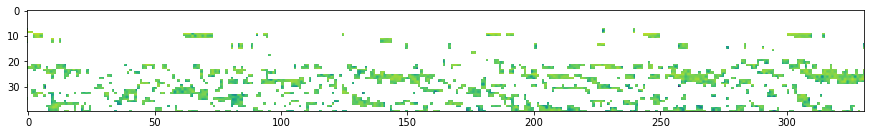

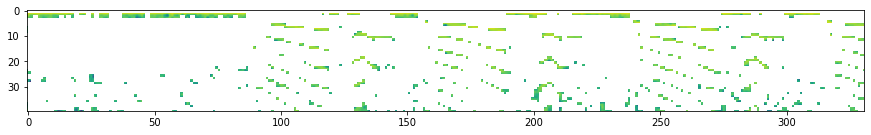

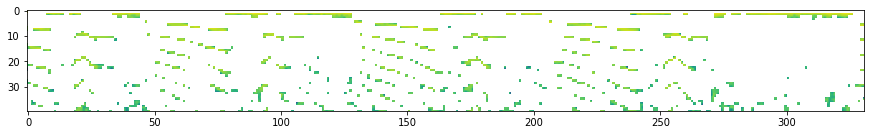

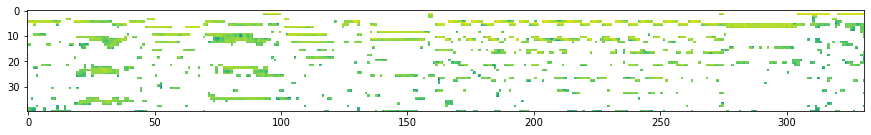

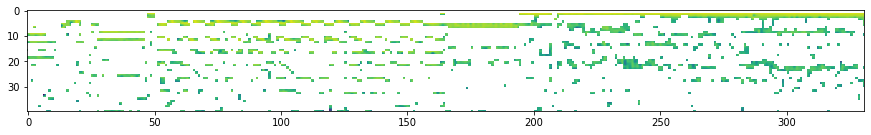

In [25]:
transformed_audio_with_lfcc_function = [transform(song) for song in loaded_songs]

def print_emb(emb):
    plt.figure(figsize=(15, 6))
    plt.imshow(emb.log2())

for i in range(0, len(loaded_songs), 5):
    print_emb(transformed_audio_with_lfcc_function[i])
    print_emb(transformed_audio_with_lfcc_function[i+1])

Определяем функцию mean_emb(emb), которая вычисляет среднее значение по измерению 1 (вдоль оси времени) для переданного ей тензора. Используем алгоритм UMAP для уменьшения размерности данных, представленных в виде векторов признаков, хранящихся в тензоре. Используем функцию plt.scatter() из модуля matplotlib.pyplot, чтобы визуализировать кластеризацию по видам.


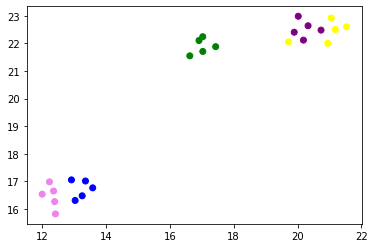

['yellow', 'green', 'purple', 'blue', 'violet']
['American Robin', "Bewick's Wren", 'Northern Cardinal', 'Northern Mockingbird', 'Song Sparrow']


In [26]:
def mean_emb(emb):
    return emb.mean(dim=1)

embedings_mean = [mean_emb(emb) for emb in transformed_audio_with_lfcc_function]
embs = umap.UMAP().fit_transform(torch.stack(embedings_mean))

colors = []
colors = np.append(colors, np.full(shape=5,fill_value='yellow'))
colors = np.append(colors, np.full(shape=5,fill_value='green'))
colors = np.append(colors, np.full(shape=5,fill_value='purple'))
colors = np.append(colors, np.full(shape=5,fill_value='blue'))
colors = np.append(colors, np.full(shape=5,fill_value='violet'))
plt.scatter(embs[:, 0], embs[:, 1], color=colors)
plt.show()

print(['yellow', 'green', 'purple', 'blue', 'violet'])
print(names)

По кластеризации можно увидеть что American Robin и Northern Cardinal похожие друг на друга теперь послушаем на звучания.

In [27]:
# American Robin
display(IPython.display.Audio('data/wavfiles/' + file_names[0]))

# Northern Cardinal
display(IPython.display.Audio('data/wavfiles/' + file_names[10]))

# Other birds
display(IPython.display.Audio('data/wavfiles/' + file_names[5]))
display(IPython.display.Audio('data/wavfiles/' + file_names[15]))
display(IPython.display.Audio('data/wavfiles/' + file_names[20]))